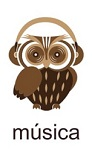

# musica
## pyspark churn prediction 

Our creation, musica, is a phoney music streaming service. Users have the option of listening to music for free (with adverts between songs) or for a set charge on this website. Users have the option to upgrade, downgrade, or cancel. It's my responsibility to foresee which users would quit their subscriptions, so I can give them a fantastic discount.

In this research, I aimed to develop a binary classifier that identifies customers who intend to leave the music service before doing so, using templates gleaned from their previous interactions and behaviours.

In [4]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [5]:
#checking memory
print('Available memory: {}'.format(spark.sparkContext.getConf().get('spark.driver.memory')))

Available memory: None


In [6]:
# import libraries
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns



from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [7]:
# Spark Session
spark = SparkSession \
    .builder \
    .appName("musica_Project") \
    .getOrCreate()

In [54]:
# Read musica dataset
path = "D:\zmusica\churn prediction\musica_data.json"
df2 = spark.read.json(path)

In [55]:
# dataset schema
df2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [56]:
# printing the number of rows in the dataframe (initial_df)
print("The number of rows in initial_df is "+ str(df2.count()))

# printing the number of columns in the dataframe (initial_df)
print("The number of columns in initial_df is "+ str(len(df2.columns)))

The number of rows in initial_df is 286500
The number of columns in initial_df is 18


In [57]:
# convert the epoch timestamp to human readable timestamp
df2 = df2.withColumn('registrationDate', (df2['registration'] / 1000).cast(TimestampType()))

In [58]:
# after converting to human readable timestamp we add that timestamp
df2 = df2.withColumn('tsDate', (df2['ts'] / 1000).cast(TimestampType()))

In [59]:
df2.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|   registrationDate|             tsDate|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|M

In [61]:
df2.select('userId', 'page', 'song', 'ts', 'tsDate').sort('ts', ascending = False).show(20)

+------+---------------+--------------------+-------------+-------------------+
|userId|           page|                song|           ts|             tsDate|
+------+---------------+--------------------+-------------+-------------------+
|100002|       NextSong|             Lullaby|1543799476000|2018-12-03 06:41:16|
|200008|       NextSong|       Come Together|1543622579000|2018-12-01 05:32:59|
|   152|       NextSong|  Stockholm Syndrome|1543622432000|2018-12-01 05:30:32|
|300011|       NextSong| The Sun On His Back|1543622411000|2018-12-01 05:30:11|
|300011|          About|                null|1543622398000|2018-12-01 05:29:58|
|200008|       NextSong|   Sed De Gol (vivo)|1543622395000|2018-12-01 05:29:55|
|   138|       NextSong|         Peace Train|1543622365000|2018-12-01 05:29:25|
|    39|       NextSong|     Caravan Of Love|1543622355000|2018-12-01 05:29:15|
|    30|Add to Playlist|                null|1543622320000|2018-12-01 05:28:40|
|    30|       NextSong|           Red C

In [62]:
# Remove rows with corrupted timestamps
df2 = df2.where(df2.ts <= 1543622399000)
df2.count()

286496


#### 1. User information

In [63]:
df2.select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration','registrationDate', 'userAgent', 'level']).show(5)

+------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
|userId|firstName|lastName|gender|            location| registration|   registrationDate|           userAgent|level|
+------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-29 03:52:42|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|2018-09-30 23:50:30|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-29 03:52:42|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|2018-09-30 23:50:30|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-29 03:52:42|Mozilla/5.0 (Wind...| paid|
+------+---------+--------+------+--------------------+---------

In [64]:
# Number of unique users in the dataset
print("Unique users in this dataset is: "+str(df2.select(['userId']).dropDuplicates().count()))


# Number of missing values in the 'userId' column 
print("missing values in the 'userId' column is: "+ str(df2.where(df2.userId.isNull()).count()))

Unique users in this dataset is: 226
missing values in the 'userId' column is: 0


In [65]:
# Rows with empty strings in the 'userId' column.
df2.where(df2.userId == "").count()

8346

In [66]:
df2.where(df2.userId == "").select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'userAgent', 'level', 'tsDate', 'page', 'auth',]).show(10)

+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|userId|firstName|lastName|gender|location|registration|userAgent|level|             tsDate| page|      auth|
+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:32:25| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:33:27| Help|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:34:01| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:34:02|Login|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:47:58| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 06:47:59|Login|Logged Out|
|      |  

In [67]:
df3 = df2.where(df2.userId == "").groupby('auth')
df3.count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



Rows with an empty string in the 'userId' column correspond to logs in which the user has not been logged in ('Logged Out' or 'Guest')

#### 2. Log-specific information

In [68]:
#  Log-specific information
df2.select(['ts', 'tsDate', 'page', 'auth', 'sessionId', 'itemInSession', 'method', 'status']).show(10)

+-------------+-------------------+---------------+---------+---------+-------------+------+------+
|           ts|             tsDate|           page|     auth|sessionId|itemInSession|method|status|
+-------------+-------------------+---------------+---------+---------+-------------+------+------+
|1538352117000|2018-10-01 05:31:57|       NextSong|Logged In|       29|           50|   PUT|   200|
|1538352180000|2018-10-01 05:33:00|       NextSong|Logged In|        8|           79|   PUT|   200|
|1538352394000|2018-10-01 05:36:34|       NextSong|Logged In|       29|           51|   PUT|   200|
|1538352416000|2018-10-01 05:36:56|       NextSong|Logged In|        8|           80|   PUT|   200|
|1538352676000|2018-10-01 05:41:16|       NextSong|Logged In|       29|           52|   PUT|   200|
|1538352678000|2018-10-01 05:41:18|       NextSong|Logged In|        8|           81|   PUT|   200|
|1538352886000|2018-10-01 05:44:46|       NextSong|Logged In|        8|           82|   PUT|   200|


In [69]:
df2.groupby('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|261060|
|   GET| 25436|
+------+------+



In [70]:
df2.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259808|
+------+------+



In [71]:
print("missing values in the 'page' column is: "+str(df2.where(df2.page.isNull()).count()))

missing values in the 'page' column is: 0


In [72]:
# pages types

num_pages = df2.select('page').dropDuplicates().count()
df2.select('page').dropDuplicates().show(num_pages)
print("number of user action is: "+str(num_pages))

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

number of user action is: 22


In [135]:
import plotly.graph_objects as go

# Convert Pandas DataFrame to Plotly-compatible format
pages_df = df2.groupby('page').count().toPandas()
pages_df_plotly = pages_df.sort_values(by='count', ascending=False)  # Sort DataFrame by count in descending order

# Create a Plotly bar plot trace
bar_plot_trace = go.Bar(
    x=pages_df_plotly['page'],  # X-axis data
    y=pages_df_plotly['count'],  # Y-axis data
    marker=dict(color='blue'),  # Set color of bars
    name='Page Traffic',  # Set trace name
)

# Create a layout for the plot
layout = go.Layout(
    title='Page Traffic (Bar Plot)',
    xaxis=dict(title='Page'),
    yaxis=dict(title='Count'),
)

# Create a Figure object
fig = go.Figure(data=[bar_plot_trace], layout=layout)

# Show the figure
fig.show()

In [74]:
df2.groupby('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278098|
+----------+------+



In [75]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column.

df2.where(df2.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

+------+-------------------+---------+---------+--------------------+
|userId|             tsDate|sessionId|     auth|                page|
+------+-------------------+---------+---------+--------------------+
|    18|2018-10-08 01:56:30|      514|Cancelled|Cancellation Conf...|
|    32|2018-10-09 02:40:46|      540|Cancelled|Cancellation Conf...|
|   125|2018-10-12 10:05:18|      174|Cancelled|Cancellation Conf...|
|   105|2018-10-13 01:47:21|      508|Cancelled|Cancellation Conf...|
|    17|2018-10-14 02:49:44|      797|Cancelled|Cancellation Conf...|
+------+-------------------+---------+---------+--------------------+
only showing top 5 rows



_'Cancelled'_ category corresponds to _'Cancellation Confirmation'_ in the page column.

In [77]:
print("Number of empty values in the sessionId column is: "+str(df2.where(df2.sessionId == "").count()))

Number of empty values in the sessionId column is: 0


In [78]:
print("total number of sessionId is : "+str(df2.select('sessionId').dropDuplicates().count()))

total number of sessionId is : 2354


In [79]:
print("missing values in the sessionId column is: "+str(df2.where(df2.sessionId.isNull()).count()))

missing values in the sessionId column is: 0


In [79]:
# maximum and minimum session length 

sessions_df = df2.where(df2.userId != "").groupby(['userId','sessionId']) \
                                            .agg(((Fmax('ts') - Fmin('ts'))/1000).alias('sessionlength'))

sessions_df.sort('sessionlength', ascending = False).show(5)
sessions_df.where(sessions_df.sessionlength != 0).sort('sessionlength', ascending = True).show(5)

+------+---------+-------------+
|userId|sessionId|sessionlength|
+------+---------+-------------+
|    91|     1840|     267305.0|
|   115|      316|     222919.0|
|   101|      635|     198001.0|
|   120|      731|     162636.0|
|    61|      529|     151481.0|
+------+---------+-------------+
only showing top 5 rows

+------+---------+-------------+
|userId|sessionId|sessionlength|
+------+---------+-------------+
|    30|      264|          1.0|
|200023|      314|          1.0|
|200025|      296|          1.0|
|200006|      150|          1.0|
|     5|      380|          1.0|
+------+---------+-------------+
only showing top 5 rows



maximum sessionlength : 74 hrs, 
minimum sessionlength : 1 sec

#### 3. Song-level information

In [80]:
# Song-level information
df2.select(['artist', 'song', 'length']).show(10)

+--------------------+--------------------+---------+
|              artist|                song|   length|
+--------------------+--------------------+---------+
|      Martha Tilston|           Rockpools|277.89016|
|    Five Iron Frenzy|              Canada|236.09424|
|        Adam Lambert|   Time For Miracles| 282.8273|
|              Enigma|Knocking On Forbi...|262.71302|
|           Daft Punk|Harder Better Fas...|223.60771|
|The All-American ...|      Don't Leave Me|208.29995|
|The Velvet Underg...|         Run Run Run|260.46649|
|        Starflyer 59|Passengers (Old A...|185.44281|
|                null|                null|     null|
|            Frumpies|          Fuck Kitty|134.47791|
+--------------------+--------------------+---------+
only showing top 10 rows



In [81]:
# number of listen songs
df2.where(df2.page == 'NextSong').groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228104|
+--------+------+



In [82]:
print("total number of songs in dataset (including full duplicates) is: "+str(df2.select(['artist','song','length']).dropDuplicates().count()))

total number of songs in dataset (including full duplicates) is: 65965


In [83]:
print("total number of songs in dataset (including duplicates with same artist and song name) is {}"+str(df2.select(['artist','song']).dropDuplicates().count()))

total number of songs in dataset (including duplicates with same artist and song name) is {}65416


In [84]:
print("total number of artists : "+str(df2.where(df2.artist.isNotNull()).select('artist').dropDuplicates().count()))

total number of artists : 17655


In [85]:
print("Number of different song names is {}"+str(df2.where(df2.song.isNotNull()).select('song').dropDuplicates().count()))

Number of different song names is {}58480


## Exploratory data analysis

In [86]:
# Drop missing userId and sessionId
df2 = df2.dropna(how = 'any', subset = ['userId','sessionId'])
df2 = df2[df2.userId != ""]

In [87]:
# add downgrade flag
df2 = df2.withColumn('downgrade', when(df2.page == 'Submit Downgrade', 1).otherwise(0))
df2 = df2.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))

# add churn
df2 = df2.withColumn('churn', when(df2.page == 'Cancellation Confirmation', 1).otherwise(0))
df2 = df2.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))

In [88]:
gender_df = df2.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().toPandas()
gender_df

,user_churn,gender,count
0,1,F,20
1,0,M,89
2,1,M,32
3,0,F,84


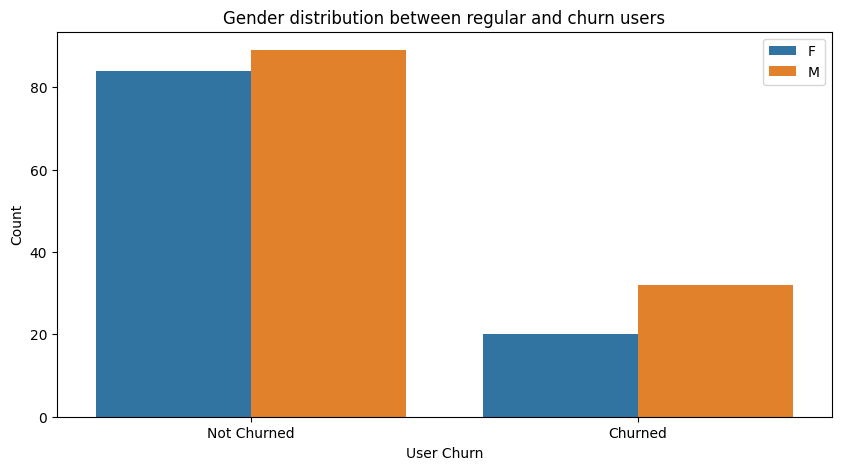

In [89]:
# Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Gender distribution between regular and churn users')
ax = sns.barplot(x = 'user_churn', y = 'count', data = gender_df, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

#%matplot plt

Q. Which group—paying or free users—cancels the service more frequently?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


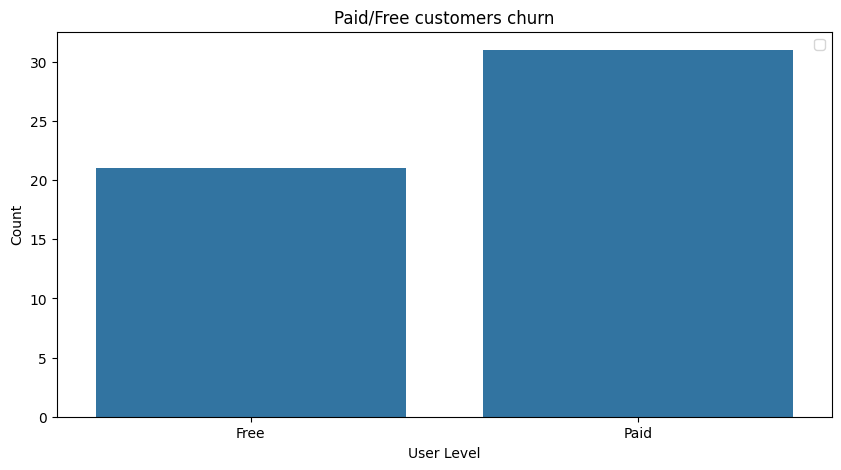

In [90]:
# Plotting a bar plot to show differense between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(10, 5))

df_paid_free = df2.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_paid_free, x = 'level', y = 'count', color = sns.color_palette()[0])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

#%matplot plt

Average number of songs played by users who subscribed and those who are not

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


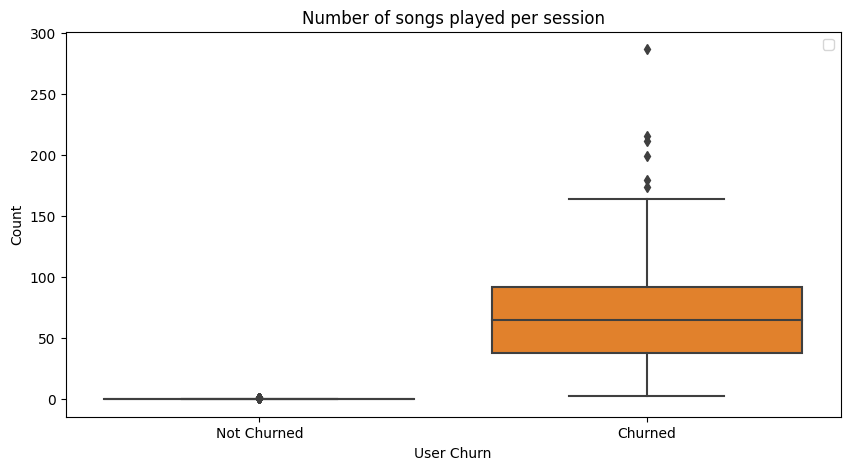

In [91]:
# Plotting Number of songs played per session

avg_songs_df = df2.where(df2.song.isNotNull()).groupby(['user_churn', 'userId', 'sessionId']).count()\
    .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Number of songs played per session')
sns.boxplot(data = avg_songs_df,orient="v")

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

#%matplot plt
#'user_churn', y = 'avg(count)', 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


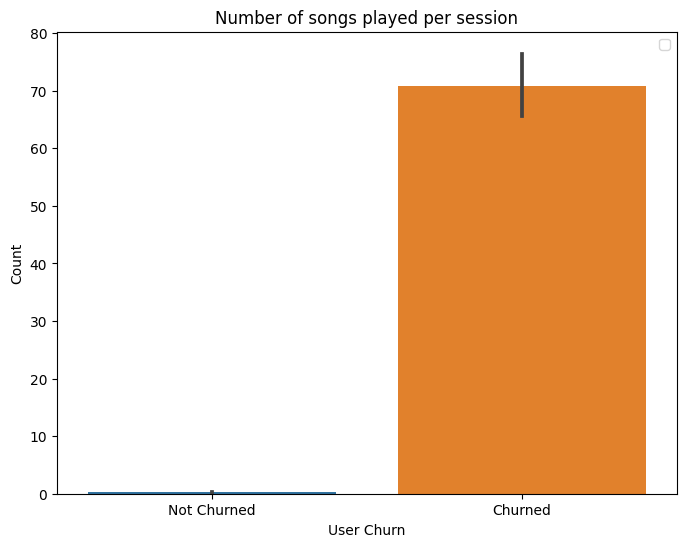

In [92]:
# seaborn code to print bar plot 
fig, ax = plt.subplots(figsize=(8,6))

plt.title('Number of songs played per session')
sns.barplot(data = avg_songs_df)

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

The average session lenght who unsubscribed versus those who did not.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21452\816549581.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
UsageError: Line magic function `%matplot` not found.


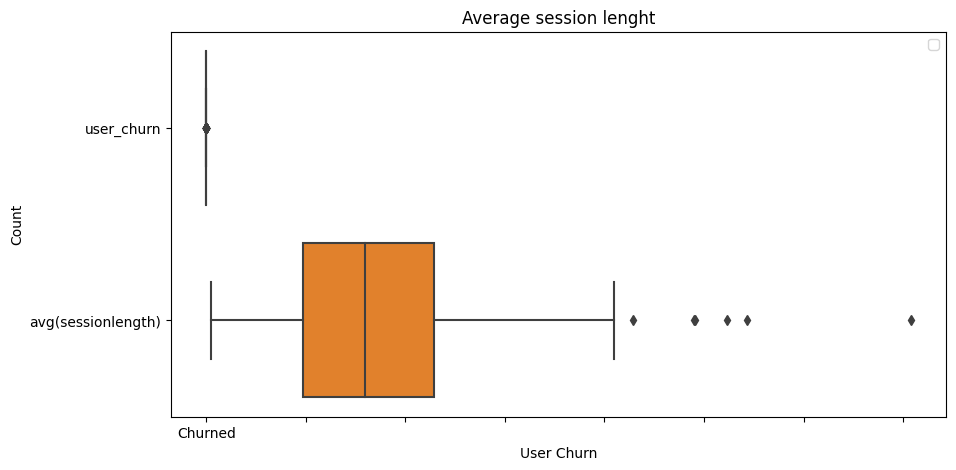

In [93]:
avg_session_df = df2.groupby(['user_churn', 'userId', 'sessionId']) \
            .agg(((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
            .groupby(['user_churn', 'userId']).agg({'sessionlength': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Average session lenght')
sns.boxplot(data = avg_session_df,orient="h")

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt
#'user_churn', y = 'avg(sessionlength)', 

In [98]:
avg_session_df

,user_churn,userId,avg(sessionlength)
0,0,10,27584.833333
1,0,100,18991.142857
2,1,100001,8889.500000
3,0,100002,16094.666667
4,1,100003,5947.000000
...,...,...,...
220,0,300016,10908.615385
221,0,37,23568.666667
222,0,66,12146.714286
223,0,67,20845.538462


In [103]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()
avg_session_df.iplot(x = avg_session_df['userId'],y = avg_session_df['avg(sessionlength)'], kind='histogram')

In [106]:
import plotly.graph_objects as go

# Create a line plot trace
lineplot_trace = go.Scatter(
    x=avg_session_df['userId'],
    y=avg_session_df['avg(sessionlength)'],
    mode='lines',
    name='Average Session Length',
)

# Create a layout for the plot
layout = go.Layout(
    title="Average Session Length",
    xaxis=dict(title='User ID'),
    yaxis=dict(title='Average Session Length'),
)

# Create a Figure object
fig = go.Figure(data=[lineplot_trace], layout=layout)

# Show the figure
fig.show()

In [107]:
import plotly.graph_objects as go

# Create a heatmap trace
heatmap_trace = go.Heatmap(
    x=avg_session_df['userId'],
    y=[0],  # Heatmap has only one row, so y-axis will have only one value
    z=[avg_session_df['avg(sessionlength)']],  # Use avg(sessionlength) as the values
    colorscale='Viridis',  # Choose a colorscale
    colorbar=dict(title='Average Session Length'),  # Add a colorbar title
)

# Create a layout for the plot
layout = go.Layout(
    title="Average Session Length Heatmap",
    xaxis=dict(title='User ID'),
    yaxis=dict(visible=False),  # Hide the y-axis
)

# Create a Figure object
fig = go.Figure(data=[heatmap_trace], layout=layout)

# Show the figure
fig.show()

In [140]:
avg_session_df.iplot(kind='bar')

Users who unsubscribe may not use the service for so long.

UsageError: Line magic function `%matplot` not found.


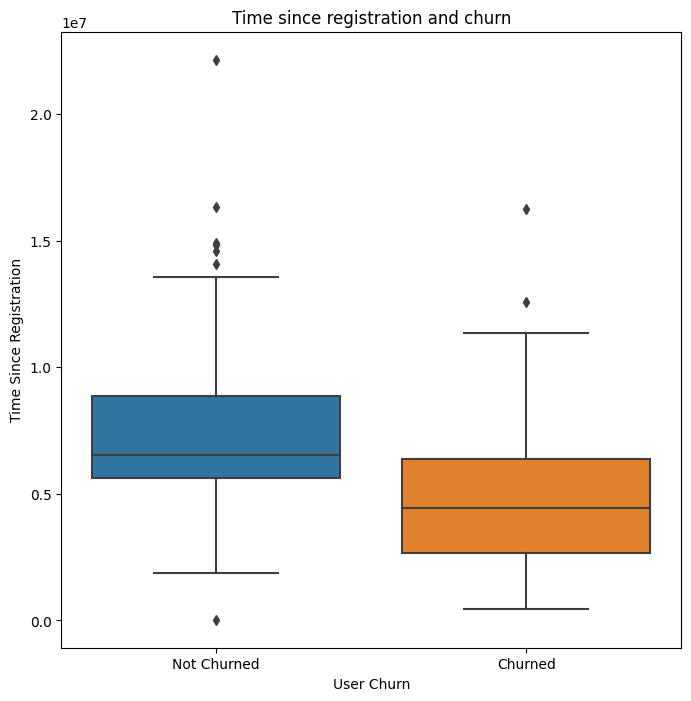

In [110]:
life_time_df = df2.groupby(['user_churn', 'userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df2.ts - df2.registration) / 1000) \
                    .groupBy('userId', 'user_churn').agg({'life_time' : 'max'}).toPandas()

# Plottint this dataframe
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=life_time_df, x='user_churn', y='max(life_time)')
plt.xlabel('User Churn')
plt.ylabel('Time Since Registration')
plt.title('Time since registration and churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

%matplot plt

In [114]:
import plotly.graph_objects as go

# Convert Pandas DataFrame to Plotly-compatible format
life_time_df_plotly = pd.melt(life_time_df, id_vars=['user_churn'], value_vars=['max(life_time)'], 
                              value_name='Time Since Registration')

# Create a Plotly box plot trace
box_plot_trace = go.Box(
    x=life_time_df_plotly['user_churn'],  # X-axis data
    y=life_time_df_plotly['Time Since Registration'],  # Y-axis data
    boxpoints='all',  # Show all data points as individual markers
    jitter=0.3,  # Add jitter for better visibility of individual markers
    pointpos=-1.8,  # Set position of individual markers
    boxmean=True,  # Show mean line inside the box
    name='Time Since Registration',  # Set trace name
    marker=dict(color='red'),  # Set color of box plot
)

# Create a layout for the plot
layout = go.Layout(
    title='Time since registration and churn (Box Plot)',
    xaxis=dict(title='User Churn'),
    yaxis=dict(title='Time Since Registration'),
)

# Create a Figure object
fig = go.Figure(data=[box_plot_trace], layout=layout)

# Show the figure
fig.show()

In [111]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

life_time_df.iplot(x ='user_churn', y='max(life_time)' ,kind='box')

How about the number of friends?

[[Text(0, 0, 'Not Churned'), Text(1, 0, 'Churned')]]

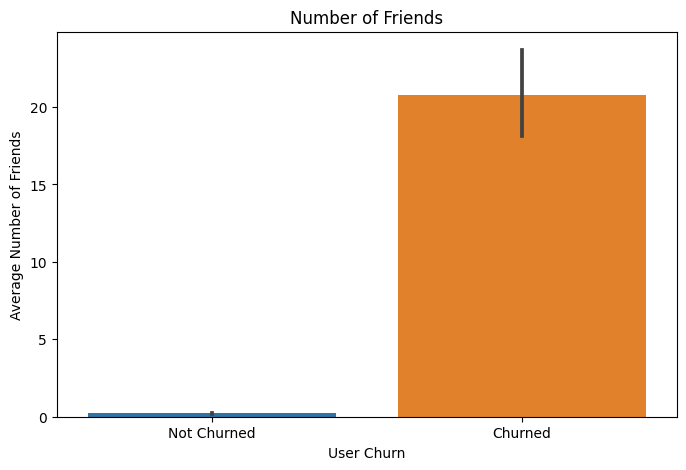

In [107]:
# dataframe whith friends
friends_df = df2.where('page == "Add Friend"').groupby(['user_churn', 'userId']).count()\
                        .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

# Plottint how Number of Friends correlations with Churn

fig, ax = plt.subplots(figsize=(8,5))

plt.title('Number of Friends')
sns.barplot(data = friends_df)
plt.ylabel('Average Number of Friends')
plt.xlabel('User Churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

In [147]:
friends_df.iplot(kind='box')

## Feature Engineering

here we extract the features that will help us create the model. We need the following features:

* Total songs listened
* Gender
* Number of thumbs down
* Number of thumbs up
* Total time since registration
* Average songs played per session
* Number of songs added to the playlist
* Total number of friends
* Help page visits 
* Settings page visits
* Errors
* Downgrade
* Paid/Free users (last label)
* Churn (target)

In [115]:
features = []

#### Total songs listened

In [116]:
songs_df = df2.select('userID', 'page').where(df2.page == 'NextSong').groupBy('userID').count() \
                    .withColumnRenamed('count', 'songs')

songs_df.show(5)

features.append(songs_df)

+------+-----+
|userID|songs|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows



#### Gender
Set Female to 1, Male to 0

In [117]:
gender_df = df2.groupby('userId').agg(first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'))

gender_df.show(5)

features.append(gender_df)

+------+------+
|userId|gender|
+------+------+
|100010|     1|
|200002|     0|
|   125|     0|
|    51|     0|
|   124|     1|
+------+------+
only showing top 5 rows



#### Number of thumbs down

In [118]:
thumbs_down_df = df2.select('userId', 'page').where(df2.page == 'Thumbs Down').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_down')

thumbs_down_df.show(5)

features.append(thumbs_down_df)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows



#### Number of thumbs up

In [119]:
thumbs_up_df = df2.select('userId', 'page').where(df2.page == 'Thumbs Up').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_up')
thumbs_up_df.show(5)

features.append(thumbs_up_df)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows



#### Total time since registration

In [121]:
time_since_registration_df = df2.groupby(['userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df2.ts - df2.registration) / 1000) \
                    .groupBy('userId').agg(Fmax('life_time')) \
                    .withColumnRenamed('max(life_time)', 'time_since_registration')

time_since_registration_df.show(5)

features.append(time_since_registration_df)

+------+-----------------------+
|userId|time_since_registration|
+------+-----------------------+
|100010|              4807612.0|
|200002|              6054448.0|
|   125|              6161779.0|
|    51|              1680985.0|
|   124|            1.1366431E7|
+------+-----------------------+
only showing top 5 rows



#### Average songs played per session

In [122]:
avg_songs_p_session_df = df2.where(df2.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).agg({'count': 'avg'}) \
                            .withColumnRenamed('avg(count)', 'avg_songs_p_session')

avg_songs_p_session_df.show(5)

features.append(avg_songs_p_session_df)

+------+-------------------+
|userId|avg_songs_p_session|
+------+-------------------+
|100010| 39.285714285714285|
|200002|               64.5|
|   125|                8.0|
|    51|              211.1|
|   124| 145.67857142857142|
+------+-------------------+
only showing top 5 rows



#### Number of songs added to playlist

In [123]:
songs_in_playlist_df = df2.select('userID', 'page') \
                            .where(df2.page == 'Add to Playlist').groupBy('userID').count() \
                            .withColumnRenamed('count', 'songs_in_playlist')

songs_in_playlist_df.show(5)

features.append(songs_in_playlist_df)

+------+-----------------+
|userID|songs_in_playlist|
+------+-----------------+
|100010|                7|
|200002|                8|
|    51|               52|
|   124|              118|
|     7|                5|
+------+-----------------+
only showing top 5 rows



#### Total number of friends

In [124]:
number_of_friends_df = df2.where('page == "Add Friend"').groupby(['userId']).count()\
                        .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'number_of_friends')
                                                                 
number_of_friends_df.show(5)

features.append(number_of_friends_df)

+------+-----------------+
|userId|number_of_friends|
+------+-----------------+
|100010|              4.0|
|200002|              4.0|
|    51|             28.0|
|   124|             74.0|
|     7|              1.0|
+------+-----------------+
only showing top 5 rows



#### Help page visits 

In [125]:
help_df = df2.groupby('userId').agg(Fsum(when(col('page') == 'Help', 1).otherwise(0)).alias('help_visits'))

help_df.show(5)

features.append(help_df)

+------+-----------+
|userId|help_visits|
+------+-----------+
|100010|          2|
|200002|          2|
|   125|          0|
|    51|         12|
|   124|         23|
+------+-----------+
only showing top 5 rows



#### Settings page visits

In [126]:
settings_df = df2.groupby('userId').agg(Fsum(when(col('page') == 'Settings', 1).otherwise(0)).alias('settings_visits'))

settings_df.show(5)

features.append(settings_df)

+------+---------------+
|userId|settings_visits|
+------+---------------+
|100010|              0|
|200002|              3|
|   125|              0|
|    51|             12|
|   124|             20|
+------+---------------+
only showing top 5 rows



#### Errors

In [127]:
errors_df = df2.groupby('userId').agg(Fsum(when(col('page') == 'Error', 1).otherwise(0)).alias('errors'))

errors_df.show(5)

features.append(errors_df)

+------+------+
|userId|errors|
+------+------+
|100010|     0|
|200002|     0|
|   125|     0|
|    51|     1|
|   124|     6|
+------+------+
only showing top 5 rows



#### Downgrade

In [128]:
downgrade_df = df2.select('userId', 'downgrade').dropDuplicates()

downgrade_df.show(5)

features.append(downgrade_df)

+------+---------+
|userId|downgrade|
+------+---------+
|    73|        0|
|    19|        0|
|200007|        0|
|    50|        0|
|    25|        1|
+------+---------+
only showing top 5 rows



#### Paid/Free users (last)

Set paid users to 1, free to 0

In [129]:
level_df = df2.groupby('userId').agg(last(when(col('level') == 'paid', 1).otherwise(0)).alias('level'))

level_df.show(5)

features.append(level_df)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|    51|    1|
|   124|    1|
+------+-----+
only showing top 5 rows



#### Churn (target)

In [130]:
churn = df2.select('userId', 'user_churn').dropDuplicates()

churn.show(5)

features.append(churn)

+------+----------+
|userId|user_churn|
+------+----------+
|    10|         0|
|   100|         0|
|100001|         1|
|100002|         0|
|100003|         1|
+------+----------+
only showing top 5 rows



In [131]:
print(features)

[DataFrame[userID: string, songs: bigint], DataFrame[userId: string, gender: int], DataFrame[userId: string, thumbs_down: bigint], DataFrame[userId: string, thumbs_up: bigint], DataFrame[userId: string, time_since_registration: double], DataFrame[userId: string, time_since_registration: double], DataFrame[userId: string, avg_songs_p_session: double], DataFrame[userID: string, songs_in_playlist: bigint], DataFrame[userId: string, number_of_friends: double], DataFrame[userId: string, help_visits: bigint], DataFrame[userId: string, settings_visits: bigint], DataFrame[userId: string, errors: bigint], DataFrame[userId: string, downgrade: int], DataFrame[userId: string, level: int], DataFrame[userId: string, user_churn: int]]


In [132]:
final_df = songs_df

def merging_dataframes(a_df, b_df):
    '''  
    INPUT: 
    a_df, b_df - dataframes to be merged
    
    OUTPUT: 
    merged_df - merged dataframe
    
    Description: 
    Join dataframes
    '''
    
    merged_df = b_df.join(a_df, on=['userId'], how='left')
    
    return merged_df

for names in features[1:]:
    final_df = merging_dataframes(final_df, names)

# fill nans
final_df = final_df.na.fill(0)
final_df.show(5)

+------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+-----------------------+---------+-----------+------+-----+
|userId|user_churn|level|downgrade|errors|settings_visits|help_visits|number_of_friends|songs_in_playlist|avg_songs_p_session|time_since_registration|time_since_registration|thumbs_up|thumbs_down|gender|songs|
+------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+-----------------------+---------+-----------+------+-----+
|    10|         0|    1|        0|     0|              7|          1|             12.0|                9| 112.16666666666667|              4472293.0|              4472293.0|       37|          4|     0|  673|
|   100|         0|    1|        1|     3|             11|         18|             49.0|               61|  78.88235294117646|              5605094.0|          

In [133]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- user_churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- errors: long (nullable = true)
 |-- settings_visits: long (nullable = true)
 |-- help_visits: long (nullable = true)
 |-- number_of_friends: double (nullable = false)
 |-- songs_in_playlist: long (nullable = true)
 |-- avg_songs_p_session: double (nullable = false)
 |-- time_since_registration: double (nullable = false)
 |-- time_since_registration: double (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- songs: long (nullable = true)



## Modeling

here we split the dataset into training, test, and validation sets. Let's test several machine learning methods. 

#### Vectorize and Standardizing 

Let's transform numeric features to Vector Assembler.

In [58]:
final_df.columns

['userId',
 'user_churn',
 'level',
 'downgrade',
 'errors',
 'settings_visits',
 'help_visits',
 'number_of_friends',
 'songs_in_playlist',
 'avg_songs_p_session',
 'time_since_registration',
 'thumbs_up',
 'thumbs_down',
 'gender',
 'songs']

In [59]:
# Create VectorAssembler and StandardScaler objects
# numeric features transform separately from binary
num_vector = VectorAssembler(inputCols=['downgrade', 'errors', 'settings_visits', 
                                        'help_visits', 'number_of_friends', 'songs_in_playlist', 
                                        'avg_songs_p_session', 'time_since_registration', 'thumbs_up', 
                                        'thumbs_down', 'songs','level', 'gender'], 
                             outputCol='num_vector_assem')

num_scaler = StandardScaler(inputCol='num_vector_assem', outputCol ='num_vector_sc', withStd=True, withMean=True)

final_vector = VectorAssembler(inputCols=['level', 'gender']+['num_vector_sc'], 
                               outputCol='features_vector')

In [60]:
# Transform data
data = num_vector.transform(final_df)

feature_standardize = num_scaler.fit(data)
data = feature_standardize.transform(data)

data = final_vector.transform(data)

In [61]:
#final data
data = data.select(data.user_churn, data.features_vector)
data.show(5)

+----------+--------------------+
|user_churn|     features_vector|
+----------+--------------------+
|         0|[1.0,0.0,-0.46581...|
|         0|[1.0,0.0,2.138943...|
|         0|[1.0,0.0,-0.46581...|
|         1|[0.0,1.0,-0.46581...|
|         0|[1.0,0.0,-0.46581...|
+----------+--------------------+
only showing top 5 rows



In [62]:
# Split Test and Train set
train, test = data.randomSplit([0.6, 0.4], seed=42)

### Functions for printing and reports

In [63]:
def evaluate_print(model_result, model_name, start, end):

    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('user_churn')
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'})
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'})
    time = (end - start)/60
    
    result = [model_name, round(accuracy,3), round(f1,3), round(time,1)]
    
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(accuracy))
    print('F-1 Score: {}'.format(f1))
    print('Total training time: {} minutes'.format(time))
    
    return result

In [64]:
def reports(model_result):
    print(model_result[0])
    print('Accuracy: {}'.format(model_result[1]))
    print('F-1 Score: {}'.format(model_result[2]))
    print('Total training time: {} minutes'.format(model_result[3]))
    
    print()

### Baseline Model

Three models, Random Forest, Logistic Regression, and Support Vector Machine, will be trained. However, we first require a baseline model. A baseline is the outcome of an extremely simple model or solution. Then, in an effort to provide a better outcome, we will try to create more complicated solutions. It is positive if we surpass the baseline score.

Assuming that the response is always 0 (i.e., no user has cancelled their subscription), we shall proceed. This will serve as our starting point.

In [65]:
#baseline model
baseline = test.withColumn('prediction', lit(0.0))
baseline.show(5)

+----------+--------------------+----------+
|user_churn|     features_vector|prediction|
+----------+--------------------+----------+
|         0|[0.0,0.0,-0.46581...|       0.0|
|         0|[0.0,0.0,-0.46581...|       0.0|
|         0|[0.0,0.0,-0.46581...|       0.0|
|         0|[0.0,0.0,-0.46581...|       0.0|
|         0|[0.0,0.0,-0.46581...|       0.0|
+----------+--------------------+----------+
only showing top 5 rows



In [66]:
#print baseline model
baseline_result = evaluate_print(baseline, 'Baseline', 0, 0)

Baseline performance metrics:
Accuracy: 0.7904761904761904
F-1 Score: 0.6979736575481257
Total training time: 0.0 minutes


In [67]:
# start training
START = time.time()

### Logistic Regression

In [68]:
numFolds = 3
lr = LogisticRegression(maxIter=10, labelCol='user_churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(train)
lr_end = time.time()

In [69]:
lr_results = lr_model.transform(test)

lr_safe = evaluate_print(lr_results, 'Logistic Regression', lr_start, lr_end)

best_param = list(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)].values())
print('Best regression parameter is {}'.format(best_param[0]))

Logistic Regression performance metrics:
Accuracy: 0.7714285714285715
F-1 Score: 0.7714285714285715
Total training time: 13.052307204405468 minutes
Best regression parameter is 0.001


### Random Forest

In [70]:
numFolds = 3
rf = RandomForestClassifier(labelCol='user_churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20])
             .addGrid(rf.maxDepth, [10,20])
             .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(train)
rf_end = time.time()

In [73]:
print(rf_paramGrid)

[{Param(parent='RandomForestClassifier_c707b0ccbc75', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_c707b0ccbc75', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10}, {Param(parent='RandomForestClassifier_c707b0ccbc75', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_c707b0ccbc75', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 20}, {Param(parent='RandomForestClassifier_c707b0ccbc75', name='numTrees', doc='Number of trees to train (>= 1).'): 20, Param(parent='RandomForestClassifier_c707b0ccbc75', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].

In [71]:
rf_results = rf_model.transform(test)

rf_safe = evaluate_print(rf_results, 'Random Forest', rf_start, rf_end)

best_param = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best number of trees {}, best depth {}'.format(best_param[0], best_param[1]))

Random Forest performance metrics:
Accuracy: 0.8571428571428571
F-1 Score: 0.8424489795918367
Total training time: 18.658093690872192 minutes
Best number of trees 20, best depth 10


### Support Vector Machine

In [75]:
numFolds = 3
svc = LinearSVC(labelCol='user_churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [5,10])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

svc_start = time.time()
svc_model = crossval.fit(train)
svc_end = time.time()

In [76]:
svc_results = svc_model.transform(test)

svc_safe = evaluate_print(svc_results, "Support Vector Machine", svc_start, svc_end)

best_param = list(svc_model.getEstimatorParamMaps()[np.argmax(svc_model.avgMetrics)].values())
print('Best number of iterations {}'.format(best_param[0]))

Support Vector Machine performance metrics:
Accuracy: 0.7904761904761904
F-1 Score: 0.6979736575481257
Total training time: 52.2825555006663 minutes
Best number of iterations 5


In [77]:
# finish training
END = time.time()

## Evaluate models

##### Performance ranking:

In [78]:
results_models_list = [baseline_result, lr_safe, rf_safe, svc_safe]

for res in results_models_list:
    reports(res)
    
#print('Total training time {} minutes'.format((END - START)/60))

Baseline
Accuracy: 0.79
F-1 Score: 0.698
Total training time: 0.0 minutes

Logistic Regression
Accuracy: 0.771
F-1 Score: 0.771
Total training time: 13.1 minutes

Random Forest
Accuracy: 0.857
F-1 Score: 0.842
Total training time: 18.7 minutes

Support Vector Machine
Accuracy: 0.79
F-1 Score: 0.698
Total training time: 52.3 minutes



Two of the four models are on the baseline model level: Logistic Regression and Support Vector Machine.

Random Forest performed better best in all respects was Random Forest.

## Summary and Future Improvement

In this project, I was able to study the musica service dataset and create functions for the modeling process. To begin with, we studied different levels of the dataset, which was the logs of each user session. The dataset allowed me to study churn and create suitable predictive features. I trained three models: Random Forest, Logistic Regression, and Support Vector Machine. Random Forest proved to be the best and can be used in the future.

In addition, feature selection was not a trivial task. In the end, I chose a set of 13 features presented above (including the target one).

In the future, the model can be improved if we have more data on user behavior or about songs.